### Import packages

In [1]:
import argparse
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import re
import pathlib
from pathlib import Path
import numpy as np

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### Import data

In [2]:
# Set the paths
base_path = "../../"
#base_path = pathlib.Path(__file__).parent.parent.parent
log_file_dir_path = pathlib.Path(base_path, "logs")
plot_dir_path = pathlib.Path(base_path, "analysis", "plots")
pypsa_earth_path = pathlib.Path(base_path, "workflow", "pypsa-earth")
network_path = pathlib.Path(pypsa_earth_path, "results", "US_2021", "networks", "elec_s_50_ec_lcopt_Co2L-200H.nc")
eia_generation_path = pathlib.Path(base_path, "analysis", "data", "generation_eia.csv")
generation_plot_path = pathlib.Path(plot_dir_path, "electricity_generation.png")
eia_capacity_path = pathlib.Path(base_path, "analysis", "data", "capacities_eia.xlsx")
installed_capacity_plot_path = pathlib.Path(plot_dir_path, "installed_capacity.png")

In [3]:
def extract_time_res(filename):
    # Convert the filename to a string (although you already did this, no need to use network_path.name)
    filename = str(filename)

    # Search for the pattern in the filename
    match = re.search(r'(\d+)(H|SEG)', filename)

    if match:
        number = np.float64(match.group(1))
        unit = match.group(2)

        if unit == 'H':
            return number
        elif unit == 'SEG':
            return 8760 / number
    else:
        return None

filepath = Path(network_path)
time_res = extract_time_res(filepath)
print(time_res)

200.0


In [4]:
# Read reference data
df_eia_generation = pd.read_csv(eia_generation_path, index_col="Unnamed: 0")
df_eia_capacity = pd.read_excel(eia_capacity_path, skiprows=1, index_col="Energy Source")

In [5]:

# Parse argument
year_list = df_eia_generation["Period"].unique().tolist()
parser = argparse.ArgumentParser()
parser.add_argument("--year", help="Year to consider for the comparison", 
                    default=2020, type=int, choices=year_list)

# Modify sys.argv to work in Jupyter/IPython environments
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Remove unwanted args

args = parser.parse_args()

# Ensure the logs directory exists
pathlib.Path(log_file_dir_path).mkdir(exist_ok=True)

# Ensure the plots directory exists
pathlib.Path(plot_dir_path).mkdir(exist_ok=True)

In [6]:
df_network = pypsa.Network(network_path)
df_eia_generation_year = df_eia_generation.loc[df_eia_generation["Period"] == args.year].squeeze()

s_max_pu = df_network.lines["s_max_pu"].unique()[0]

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/li

In [7]:
df_network.statistics().round(1)

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           1.0         2.470722e+09   
            Coal                              0.6         2.759771e+10   
            Combined-Cycle Gas                0.5         2.652091e+10   
            Csp                               NaN         0.000000e+00   
            Geothermal                        1.0         1.294716e+09   
            Nuclear                           1.0         4.408223e+10   
            Offshore Wind (AC)                0.1         1.237435e+07   
            Offshore Wind (DC)                NaN         0.000000e+00   
            Oil                               0.0         1.209921e+09   
            Onshore Wind                      0.3         1.454208e+10   
            Open-Cycle Gas                    0.0         1.146441e+10   
            Solar                             0.1         3.061590e+09   
Line        AC                                0.3         2.055732e+10   
Link        B2B                               0.7         0.000000e+00   
            Csp                               0.7         0.000000e+00   
            DC                                0.9         3.365098e+09   
            H2 electrolysis                   inf         0.000000e+00   
            H2 fuel cell                      inf         0.000000e+00   
            battery charger                   NaN         0.000000e+00   
            battery discharger                inf         0.000000e+00   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              0.0         3.535098e+09   
            Reservoir & Dam                   0.9         0.000000e+00   
Store       Battery Storage                   inf         0.000000e+00   
            Csp                               inf         0.000000e+00   
            Hydrogen Storage                  inf         0.000000e+00   

                                  Curtailment      Dispatch  \
            carrier                                           
Generator   Biomass                       0.0  7.785012e+07   
            Coal                          0.0  1.245760e+09   
            Combined-Cycle Gas            0.0  1.338505e+09   
            Csp                           0.0  0.000000e+00   
            Geothermal                    0.0  3.391346e+07   
            Nuclear                       0.0  8.756522e+08   
            Offshore Wind (AC)            0.0  5.004430e+04   
            Offshore Wind (DC)            0.0  0.000000e+00   
            Oil                           0.0  0.000000e+00   
            Onshore Wind                  1.6  3.016434e+08   
            Open-Cycle Gas                0.0  3.770829e+07   
            Solar                         0.4  7.880049e+07   
Line        AC                            NaN -1.002567e+08   
Link        B2B                           NaN -9.288206e+05   
            Csp                           NaN  0.000000e+00   
            DC                            NaN  9.944531e+07   
            H2 electrolysis               NaN -0.000000e+00   
            H2 fuel cell                  NaN -0.000000e+00   
            battery charger               NaN  0.000000e+00   
            battery discharger            NaN -0.000000e+00   
Load        -                             NaN -4.641143e+09   
StorageUnit Pumped Hydro Storage          0.0  0.000000e+00   
            Reservoir & Dam               0.0  6.512601e+08   
Store       Battery Storage               NaN  0.000000e+00   
            Csp                           NaN -0.000000e+00   
            Hydrogen Storage              NaN  0.000000e+00   

                                  Installed Capacity  Market Value  \
            carrier                                                  
Generator   Biomass                           8887.0    

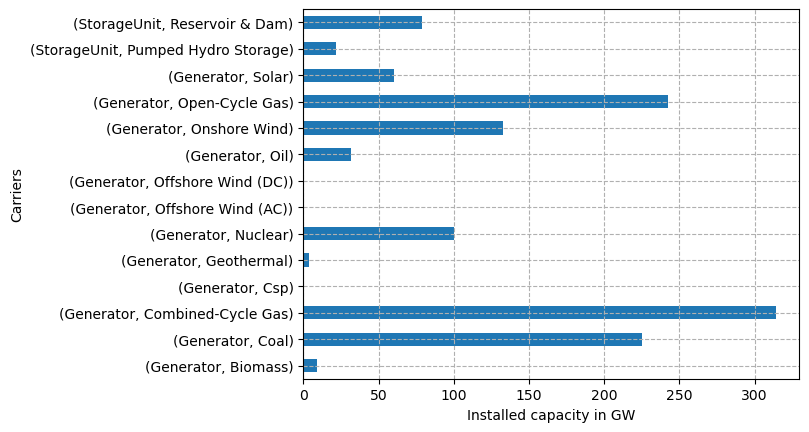

In [8]:
stats = df_network.statistics().round(1)["Installed Capacity"] / 1e3
installed_cap = stats.loc[["Generator","StorageUnit"]]
# installed_cap = installed_cap.drop(('Generator','load'))
installed_cap.plot(kind='barh')
plt.xlabel("Installed capacity in GW")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

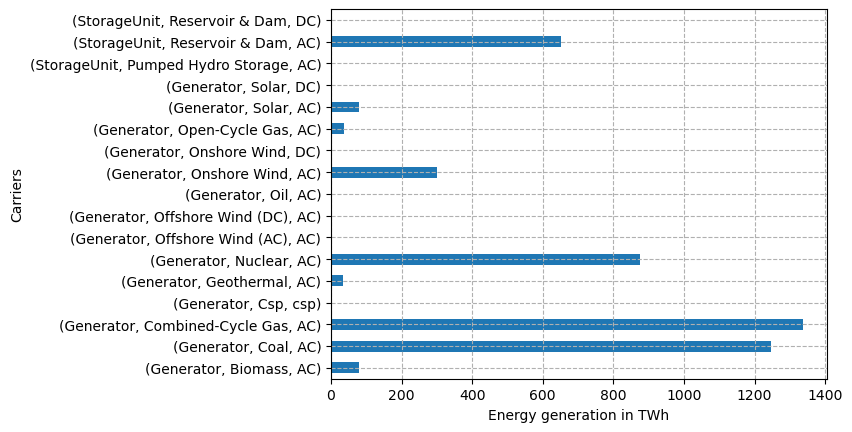

In [9]:
stats = df_network.statistics.energy_balance() / 1e6
energy_gen = stats.loc[["Generator","StorageUnit"]]
# energy_gen = energy_gen.drop(('Generator','load'))
energy_gen.plot(kind='barh')
plt.xlabel("Energy generation in TWh")
plt.ylabel("Carriers")
plt.grid(linestyle='--')

In [10]:
df_network.generators = df_network.generators.assign(p = df_network.generators_t.p.sum() * time_res)
df_pypsa = df_network.generators.groupby("carrier").p.sum()
df_pypsa.loc['wind'] = df_pypsa.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa = df_pypsa.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa /= 1e6
df_pypsa = df_pypsa.round(2)
df_pypsa.name = 'pypsa'

In [11]:
# Initial configurations
eia_name = "EIA"
pypsa_name = "PyPSA"

# Installed capacity comparison

In [12]:
# ---> Prepare the PyPSA results
df_pypsa_hydro_phs_capacity = df_network.storage_units.groupby("carrier").p_nom_opt.sum()
df_pypsa_capacity = pd.concat([df_network.generators.groupby("carrier").p_nom_opt.sum(), df_pypsa_hydro_phs_capacity])
df_pypsa_capacity.loc["wind"] = df_pypsa_capacity.loc[["offwind-ac", "offwind-dc", "onwind"]].sum()
df_pypsa_capacity = df_pypsa_capacity.drop(["offwind-ac", "offwind-dc", "onwind"])
df_pypsa_capacity /= 1000
df_pypsa_capacity = df_pypsa_capacity.round(2)
df_pypsa_capacity.name = pypsa_name

df_pypsa_capacity

carrier
CCGT          313.97
OCGT          242.71
biomass         8.89
coal          225.27
csp             0.00
geothermal      3.87
nuclear        99.96
oil            31.64
solar          60.20
PHS            22.01
hydro          79.10
wind          133.09
Name: PyPSA, dtype: float64

In [13]:
# ---> Prepare the EIA reference data
df_eia_capacity.index = df_eia_capacity.index.str.lower()
df_eia_capacity.loc["other biomass"] = df_eia_capacity.loc[["other biomass", "wood and wood-derived fuels"]].sum()
df_eia_capacity = df_eia_capacity.rename(index={"hydroelectric conventional": "hydro", "hydroelectric pumped storage": "PHS" , "solar photovoltaic": "solar", "natural gas": "CCGT", "petroleum": "oil", "other biomass": "biomass"})
df_eia_capacity = df_eia_capacity.drop(["estimated total solar", "solar thermal", "wood and wood-derived fuels", "other energy sources", "total", "small scale photovoltaic", "estimated total photovoltaic", "other gases",])
df_eia_capacity = df_eia_capacity.iloc[:-1]
df_eia_capacity.loc["solar", "Generator Nameplate Capacity"] = df_eia_capacity.loc["solar", "Net Summer Capacity"]
df_eia_capacity = df_eia_capacity["Generator Nameplate Capacity"]
df_eia_capacity.name = eia_name
df_eia_capacity /= 1000


In [14]:
# ---> Prepare comparison dataframe
df_compare_capacity = pd.concat([df_pypsa_capacity, df_eia_capacity], axis=1)

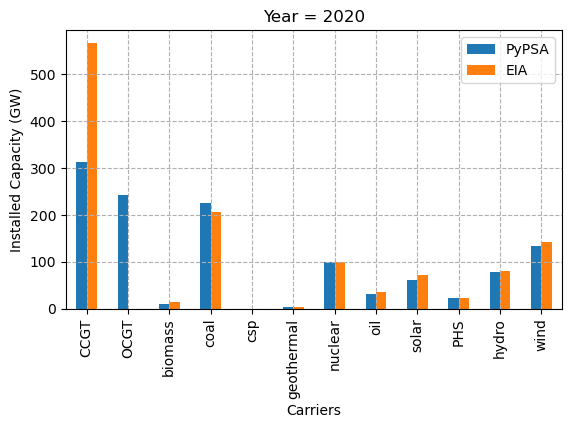

In [15]:
df_compare_capacity.plot(kind="bar")
plt.xlabel("Carriers")
plt.ylabel("Installed Capacity (GW)")
plt.title(f"Year = {args.year}")
plt.grid(linestyle="--")
plt.subplots_adjust(bottom=0.3)
plt.savefig(installed_capacity_plot_path, dpi=800)

In [16]:
df_compare_capacity.sum()

PyPSA      1220.71
EIA      1239.3987
dtype: object

# Electricity generation comparison

In [17]:
df_network.generators = df_network.generators.assign(p = df_network.generators_t.p.sum() * time_res)
df_pypsa_hydro_phs_gen = df_network.storage_units.assign(p = df_network.storage_units_t.p.sum() * time_res)
df_pypsa = df_network.generators.groupby("carrier").p.sum()
df_pypsa = pd.concat([df_pypsa,df_pypsa_hydro_phs_gen.groupby("carrier").p.sum()])
df_pypsa.loc['wind'] = df_pypsa.loc[["offwind-ac","offwind-dc","onwind"]].sum()
df_pypsa = df_pypsa.drop(["offwind-ac","offwind-dc","onwind"])
df_pypsa /= 1e6
df_pypsa = df_pypsa.round(2)
df_pypsa.name = 'pypsa'

In [18]:
df_eia = pd.read_csv("../data/generation_eia.csv",index_col="Unnamed: 0")
df_eia_2020 = df_eia.iloc[6]
df_eia_2020.name = 'EIA_2020'
df_eia_2021 = df_eia.iloc[7]
df_eia_2021.name = 'EIA_2021'

In [19]:
#Ignoring the rest which adds up to 2% of the total generation (4109 TWh)
pypsa_cols = ['Coal','Natural Gas','Other Gas','Nuclear','Hydro','Solar PV','PHS','Petroleum','Wind','Other Waste Biomass','Geothermal']
rename_cols = {'solar pv':'solar','other waste biomass':'biomass','hydro':'hydro','natural gas':'CCGT','petroleum':'oil'}

# year 2020
df_eia_2020 = df_eia_2020[pypsa_cols]
df_eia_2020.index = df_eia_2020.index.str.lower()
df_eia_2020 = df_eia_2020.rename(index=rename_cols)

# year 2021
df_eia_2021 = df_eia_2021[pypsa_cols]
df_eia_2021.index = df_eia_2021.index.str.lower()
df_eia_2021 = df_eia_2021.rename(index=rename_cols)

df_eia_2021

coal           897.999
CCGT          1579.190
other gas       11.397
nuclear        779.645
hydro          251.585
solar          112.335
phs             -5.112
oil             19.174
wind           378.197
biomass          2.267
geothermal      15.975
Name: EIA_2021, dtype: float64

In [20]:
df_compare = pd.concat([df_pypsa, df_eia_2021],axis=1)
# df_compare["error"] = df_compare.apply(lambda x: abs(x['pypsa'] - x['EIA_2021'])*100 / x['EIA_2021'],axis=1)
df_compare

,pypsa,EIA_2021
CCGT,1346.15,1579.190
OCGT,38.35,NaN
biomass,78.21,2.267
coal,1251.19,897.999
csp,0.00,NaN
geothermal,34.07,15.975
nuclear,879.65,779.645
oil,0.00,19.174
solar,79.09,112.335
PHS,0.00,NaN


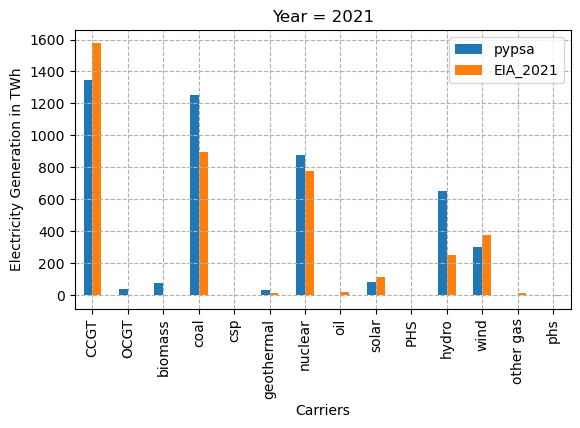

In [21]:
# Comparing the carrier mix
df_compare.plot(kind='bar')
plt.xlabel('Carriers')
plt.ylabel('Electricity Generation in TWh')
plt.grid(linestyle='--')
plt.title('Year = 2021')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../02_Plots/Electricity_gen_comparison_200H.png",dpi=800)

## Total Electricity Demand in TWh

In [22]:
df_network.loads_t.p.sum().sum() * time_res / 1e6

4664.035226185289

## Total Electricity Generation in TWh

In [23]:
(df_network.generators_t.p.sum().sum() + df_network.storage_units_t.p.sum().sum() ) * time_res / 1e6

4664.035225788987

# Dispatch timeseries in GW

In [24]:
def plot_dispatch(n, time="2015-07"):

    # if not n.links.empty:
    #     links = (
    #         n.links_t.p1.groupby(n.links.carrier, axis=1).sum().div(1e3) * -1
    #     )
    #     links = links[conv_carriers]
    #     p_by_carrier = links
    n.carriers.loc['load','color'] = 'black'
    carrier_order = ["nuclear","CCGT","OCGT","oil","coal","solar","onwind","offwind-ac","offwind-dc","geothermal","biomass"]
    gen_car = n.generators.query('carrier != "load"').carrier.unique()
    generators = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    p_by_carrier = generators[carrier_order]

    if not n.storage_units.empty:
        sto = (
            n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        )
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p_by_carrier.columns.map(n.carriers.color)

    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p_by_carrier.where(p_by_carrier < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
#             color=charge.columns.map(n.carriers.color)
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k",linewidth=1)

    plt.legend(loc=(1.05, 0),fontsize=8)
    handles = ax.legend_.legendHandles
    labels = [elt.get_text() for elt in ax.legend_.texts]
    ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1, 1.1))
    ax.set_ylabel("GW")
    ax.set_ylim(-5, 1000)
#     plt.subplots_adjust(right=0.8)
    ax.grid(linestyle="--")

In [25]:
df_network.generators.query('carrier != "load"').carrier.unique()

array(['CCGT', 'OCGT', 'biomass', 'coal', 'csp', 'nuclear', 'offwind-ac',
       'offwind-dc', 'oil', 'onwind', 'solar', 'geothermal'], dtype=object)

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/1325965963.py:12: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/1325965963.py:17: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



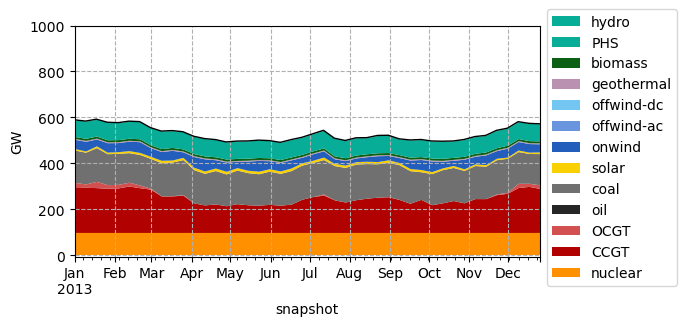

In [26]:
plot_dispatch(df_network,"2013")

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.patches import Patch

def add_legend_patches(ax, colors, labels, legend_kw):
    patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]
    ax.legend(handles=patches, **legend_kw)


def plot_map(n, plot_type, key):
    carriers = n.carriers.index.tolist()[:-2]
    buses = n.buses.query('carrier == "AC" and index != "US0 7"')
    bus_index = buses.index.tolist()
    fig = plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.EqualEarth())
    n.lines.loc[n.lines.bus0 == 'US0 19','s_nom'] = 0

    if plot_type == "capacity":
        cap = n.generators.query("carrier != 'load' and bus in @bus_index").groupby(["bus", "carrier"]).p_nom.sum()
        cap = cap[cap.index.get_level_values('bus') != 'US0 19']

        # Filter carriers with positive capacity, and avoid KeyError by checking presence in index
        carriers_with_capacity = []
        for carrier in carriers:
            if carrier in cap.index.get_level_values('carrier'):
                total_capacity = cap.xs(carrier, level='carrier').sum()
                if total_capacity > 0:
                    carriers_with_capacity.append(carrier)

        n.plot(
            ax=ax,
            bus_sizes=cap / 2e4,
            line_widths=n.lines.s_nom / 1e4,
            line_colors='rosybrown',
            margin=0.25,
            bus_alpha=0.8,
            color_geomap=True,
            link_alpha=0
        )

        values = n.generators.query("carrier != 'load' and bus in @bus_index").groupby("bus").p_nom.sum()
        sizes = np.sort(round(values / 1e3).unique() * 1e3 / 2e4)
        labels = np.sort(round(values / 1e3).unique())
        title = "Capacity (GW)"
        x_val = 1.25

        # Add the legend with filtered carriers
        add_legend_patches(
            ax, 
            colors=[n.carriers.loc[carrier].color for carrier in carriers_with_capacity], 
            labels=carriers_with_capacity, 
            legend_kw=dict(frameon=False, bbox_to_anchor=(0, 1), title="Carriers")
        )
        
    # Additional features like coastlines and borders
    #ax.add_feature(LAND)
    #ax.coastlines()
    #ax.add_feature(BORDERS, alpha=1, edgecolor='black')


/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



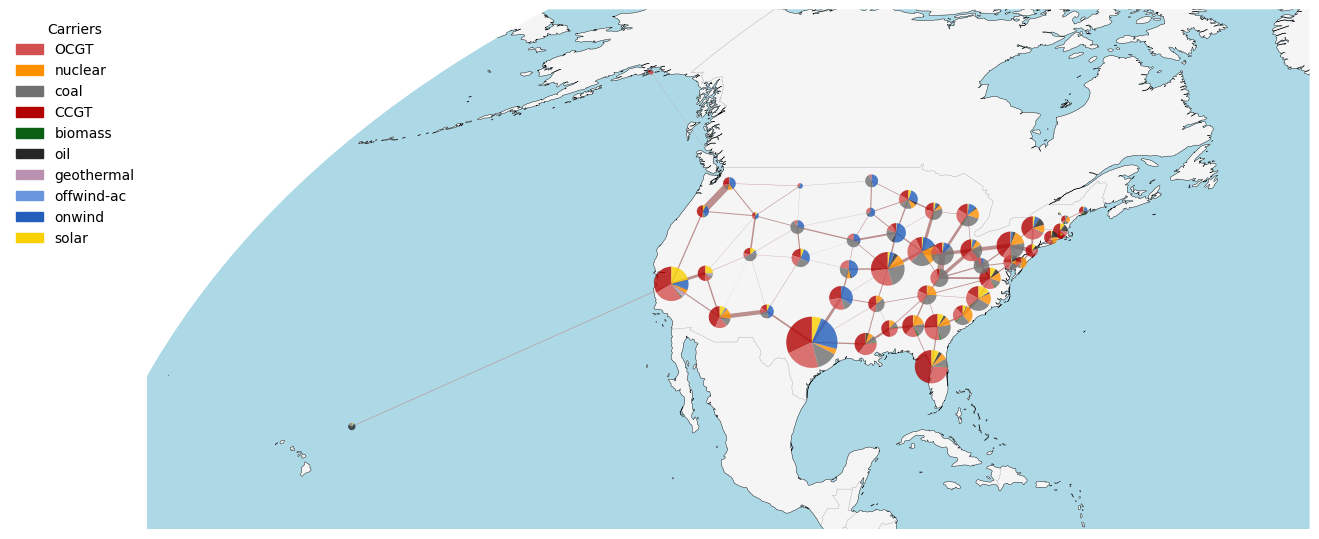

In [28]:
plot_map(df_network,"capacity","")

# Demand timeseries in GW

<AxesSubplot:xlabel='snapshot'>

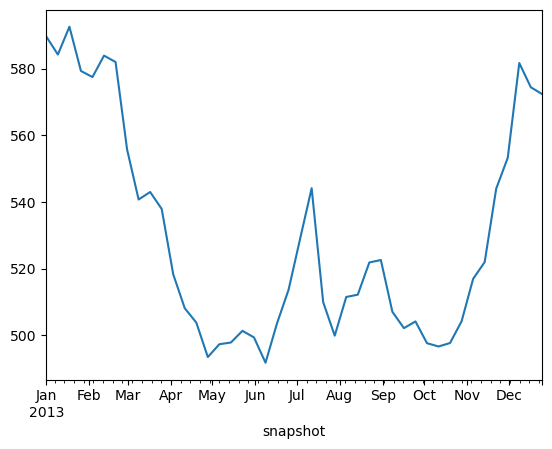

In [29]:
(df_network.loads_t.p_set.sum(axis=1) / 1e3).plot()

# Generation timeseries in GW

<AxesSubplot:xlabel='snapshot'>

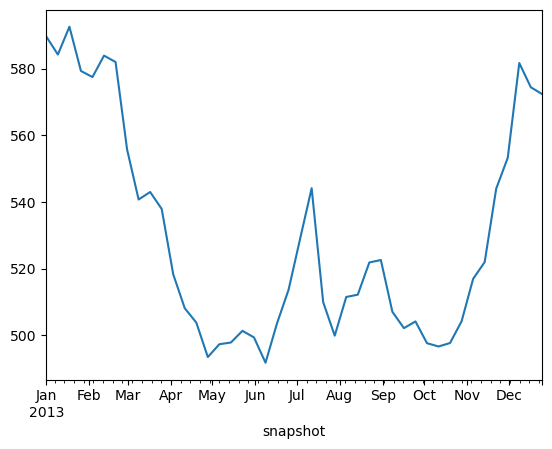

In [30]:
((df_network.generators_t.p.sum(axis=1) + df_network.storage_units_t.p.sum(axis=1)) / 1e3).plot()

In [31]:
df_eia_monthly = pd.read_csv("../data/monthly_generation_US.csv",skiprows=4)
df_eia_monthly = df_eia_monthly.dropna(axis=0)
# df_eia_monthly = df_eia
df_eia_monthly.sort_index(ascending=False)[1:-1].reset_index()

,index,Month,all fuels (utility-scale) thousand megawatthours,coal thousand megawatthours,natural gas thousand megawatthours,nuclear thousand megawatthours,conventional hydroelectric thousand megawatthours,other renewables thousand megawatthours,hydro-electric pumped storage thousand megawatthours,other gases thousand megawatthours,petroleum liquids thousand megawatthours
0,22,Jan 2021,180728.45032,66231.49971,53913.46978,34339.450,18611.53183,6207.66901,-339.236,5.19332,1188.16274
1,21,Feb 2021,163642.61950,46241.08298,53745.50684,35324.705,18970.96776,8346.53567,-141.503,8.61941,599.04253
2,18,Mar 2021,151505.03330,40783.61682,54242.56159,30125.961,17255.70913,8281.45845,-101.948,-0.38473,611.02053
3,17,Apr 2021,170418.81556,49416.68259,57584.38116,33490.728,21177.86466,8037.76082,-322.855,-0.28468,635.12736
4,14,May 2021,207175.70902,66423.90191,74851.67559,36854.337,21826.51122,6434.49710,-269.964,-0.27507,671.97540
5,13,Jun 2021,226361.26789,76451.54978,84946.61256,38370.528,20109.28476,5808.25001,-550.845,-0.26008,652.04572
6,10,Jul 2021,227826.91444,77465.31171,85233.24209,38751.840,18598.49465,6727.14729,-531.015,-0.27507,935.49064
7,9,Aug 2021,185991.21152,60310.64295,66831.68497,35305.664,15288.52205,7301.00061,-313.409,0.00000,740.36142
8,8,Sep 2021,166407.27799,45722.47543,62206.18236,34522.285,15382.67232,7659.95553,-333.460,0.00000,690.40235
9,5,Oct 2021,162701.85066,41645.58231,58942.31276,34882.319,17372.67955,8852.16839,-301.523,0.00000,647.13462


In [32]:
df_pypsa_grouped = df_network.generators_t.p.groupby(df_network.generators.carrier,axis=1).sum() * time_res
df_pypsa_sto_grouped = df_network.storage_units_t.p.groupby(df_network.storage_units.carrier,axis=1).sum() * time_res
df_pypsa_grouped = pd.concat([df_pypsa_grouped,df_pypsa_sto_grouped]) 
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.sum(axis=1).div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/4091707705.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/4091707705.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



0     469.123709
1     459.807274
2     324.324154
3     404.747098
4     399.183482
5     301.815782
6     416.585877
7     413.629032
8     302.675555
9     399.244719
10    427.224727
11    345.673817
Name: PyPSA, dtype: float64

In [33]:
df_eia = pd.read_excel("../data/Table_7.2a_Electricity_Net_Generation__Total_(All_Sectors).xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Net Generation Total (including from sources not shown), All Sectors"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0     349.209709
1     323.899529
2     311.397276
3     293.307944
4     320.180962
5     373.856478
6     405.624091
7     412.864768
8     347.743775
9     320.201778
10    314.309521
11    337.103561
Name: EIA, dtype: object

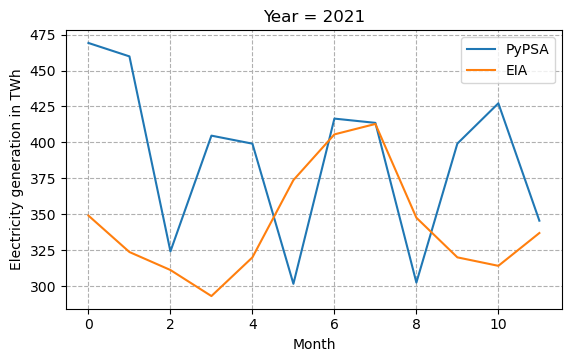

In [34]:
df_compare_gen_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021],axis=1)
df_compare_gen_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity generation in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_gen_ts.png",dpi=800)

In [35]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2021 = df_eia.loc[df_eia.Month.dt.year == 2021].reset_index()
df_eia_monthly_2021 = df_eia_monthly_2021["Electricity End Use, Total"]
# df_eia_monthly_2021 = df_eia_monthly_2021["Electricity Sales to Ultimate Customers, Total"]
df_eia_monthly_2021 = df_eia_monthly_2021 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2021.name = 'EIA'
df_eia_monthly_2021

0      333.97653
1     309.816283
2     306.272657
3      283.32879
4     301.122292
5     350.199269
6     386.625923
7     393.627941
8     347.832293
9     313.613342
10    298.838866
11    319.535135
Name: EIA, dtype: object

In [36]:
df_eia = pd.read_excel("../data/Table_7.6_Electricity_End_Use_and_Electric_Vehicle_Use.xlsx",skiprows=10)
df_eia_monthly_2020 = df_eia.loc[df_eia.Month.dt.year == 2020].reset_index()
df_eia_monthly_2020 = df_eia_monthly_2020["Electricity End Use, Total"]
df_eia_monthly_2020 = df_eia_monthly_2020 / 1000
# # df_eia_monthly_2021 = df_eia_monthly_2021.reset_index()
df_eia_monthly_2020.name = 'EIA 2020'
df_eia_monthly_2020

0     328.246135
1     306.425243
2       301.7527
3     273.132424
4     285.627076
5     331.355301
6     391.577954
7     380.979969
8     333.682753
9     307.869372
10    288.228154
11    327.499941
Name: EIA 2020, dtype: object

In [37]:
df_pypsa_grouped = df_network.loads_t.p.sum(axis=1) * time_res
df_pypsa_monthly = df_pypsa_grouped.groupby(df_pypsa_grouped.index.month).sum()
df_pypsa_monthly = df_pypsa_monthly.div(1e6)
df_pypsa_monthly.name = 'PyPSA'
df_pypsa_monthly.index = np.arange(0,12)
df_pypsa_monthly

0     469.123709
1     459.807274
2     324.324154
3     404.747099
4     399.183482
5     301.815782
6     416.585878
7     413.629032
8     302.675555
9     399.244719
10    427.224727
11    345.673817
Name: PyPSA, dtype: float64

In [38]:
# df_bev = pd.read_csv("../data/demand_BEV.csv")
df_bev = pd.read_csv("../data/demand_basegrid.csv")
df_bev = df_bev.set_index("UTC Time")
df_bev_monthly = df_bev.groupby(pd.to_datetime(df_bev.index).month).sum()
# df_bev_monthly = df_bev_monthly.sum() 
df_bev_monthly = df_bev_monthly.sum(axis=1)
df_bev_monthly = df_bev_monthly / 1e6
df_bev_monthly.name = 'BEV'
df_bev_monthly.index = np.arange(0,12)
df_bev_monthly


0     346.611661
1     307.499217
2     299.358134
3     286.032168
4     309.570943
5     361.636612
6     405.939259
7     402.971036
8     345.669695
9     307.225100
10    292.291317
11    339.831745
Name: BEV, dtype: float64

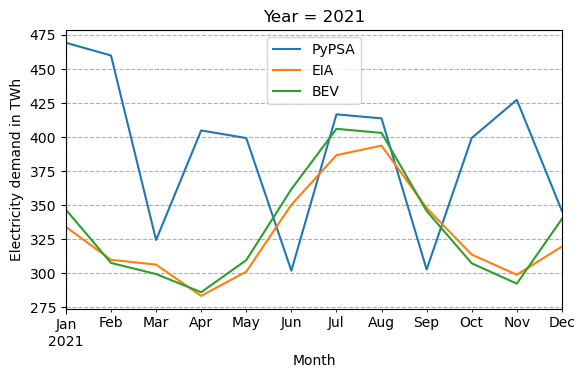

In [39]:
df_compare_dem_ts = pd.concat([df_pypsa_monthly,df_eia_monthly_2021,df_bev_monthly],axis=1)
df_compare_dem_ts.index = df_eia.loc[df_eia.Month.dt.year == 2021].Month.tolist()
df_compare_dem_ts.plot()
plt.xlabel('Month')
plt.ylabel('Electricity demand in TWh')
plt.title('Year = 2021')
plt.grid(linestyle='--')
plt.subplots_adjust(bottom=0.3)
plt.savefig("../plots/electricity_demand_ts.png",dpi=800)

In [40]:
df_network.generators.loc[df_network.generators['carrier'] == 'coal']

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,control,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p
Generator,,,,,,,,,,,,,,,,,,,,,
US.10_1_AC coal,inf,0.0,4917.6,122511.868536,0.464,4917.6,24.113033,US.10_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4.327488e+07
US.11_1_AC coal,inf,0.0,8966.6,122511.868536,0.464,8966.6,24.113905,US.11_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,7.482634e+06
US.12_1_AC coal,inf,0.0,203.0,122511.868536,0.464,203.0,24.113420,US.12_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.786400e+06
US.13_1_AC coal,inf,0.0,6.2,122511.868536,0.464,6.2,24.112804,US.13_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.356000e+04
US.14_1_AC coal,inf,0.0,10646.7,122511.868536,0.464,10646.7,24.112627,US.14_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,6.828491e+07
US.15_1_AC coal,inf,0.0,17296.9,122511.868536,0.464,17296.9,24.112668,US.15_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.160002e+08
US.16_1_AC coal,inf,0.0,4460.0,122511.868536,0.464,4460.0,24.113749,US.16_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.000000e+00
US.17_1_AC coal,inf,0.0,4624.6,122511.868536,0.464,4624.6,24.113704,US.17_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,2.587137e+07
US.18_1_AC coal,inf,0.0,10910.5,122511.868536,0.464,10910.5,24.112906,US.18_1_AC,coal,,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,9.601240e+07


In [41]:
generators = df_network.generators
coal_gas_plants = generators[generators['carrier'].isin(['CCGT', 'coal'])]
grouped_coal_gas_plants = coal_gas_plants.groupby('bus').apply(
    lambda x: pd.DataFrame({
        'indices': x.index.tolist(),
        'p_nom': x['p_nom'].tolist()
    })
).reset_index(level=1, drop=True)

grouped_coal_gas_plants 


/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/2718332946.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,indices,p_nom
bus,,
US.10_1_AC,US.10_1_AC CCGT,30217.6
US.10_1_AC,US.10_1_AC coal,4917.6
US.11_1_AC,US.11_1_AC CCGT,10175.3
US.11_1_AC,US.11_1_AC coal,8966.6
US.12_1_AC,US.12_1_AC CCGT,13.4
...,...,...
US.6_1_AC,US.6_1_AC CCGT,3914.2
US.6_1_AC,US.6_1_AC coal,4581.2
US.7_1_AC,US.7_1_AC CCGT,4166.6


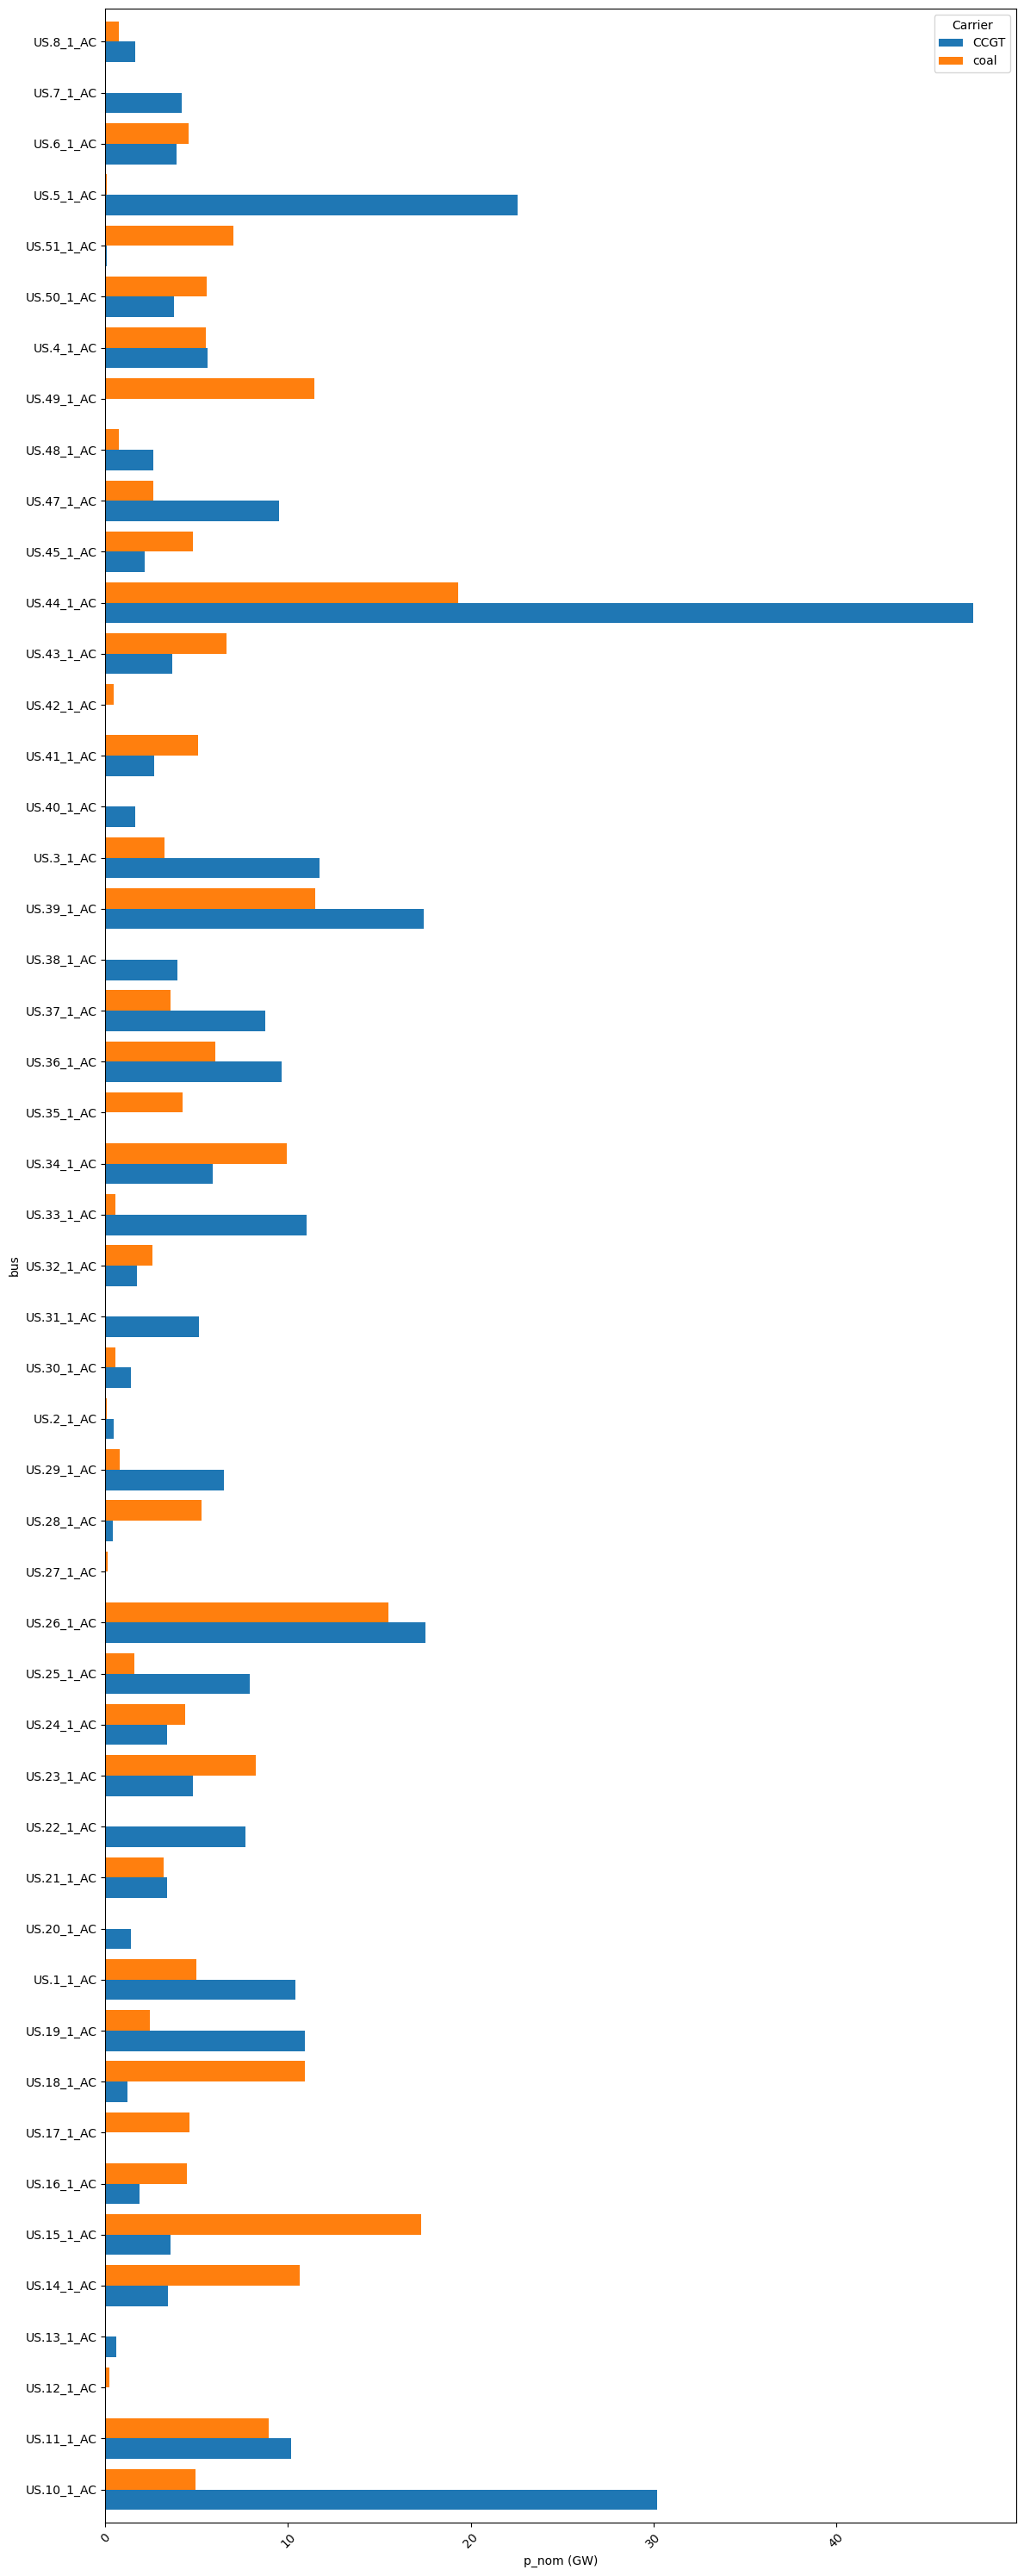

In [42]:
summary = coal_gas_plants.groupby(['bus', 'carrier'])['p_nom'].sum().div(1e3).unstack(fill_value=0)
summary.reindex(sorted(summary.index, key=lambda x: (x[3:])),axis=0)
# summary = summary.reindex(sorted(summary.index, key=lambda x: int(x[3:])), axis=0)

summary.plot(kind='barh', figsize=(12, 30), width=0.8)

plt.xlabel('p_nom (GW)')
plt.ylabel('bus')
plt.legend(title='Carrier')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#fig.savefig('../plots/coal_ccgt_comparison.pdf', dpi=1000)

# CO2 emissions in Mtonnes

In [43]:
e = (
    df_network.generators_t.p
    / df_network.generators.efficiency
    * df_network.generators.carrier.map(df_network.carriers.co2_emissions)
)
emissions = df_network.snapshot_weightings.generators @ e.sum(axis=1).div(1e6)

In [44]:
emissions #emissions in Mtonnes

1472.7999992547414

## Interstate power flow validation

In [58]:
import geopandas as gpd
gadm_usa_json_path = "../data/gadm41_USA_1.json"
gadm_gdp_usa = gpd.read_file(gadm_usa_json_path)
gadm_gdp_usa_state = gadm_gdp_usa[["GID_1", "ISO_1"]]
gadm_gdp_usa_state["state"] = gadm_gdp_usa_state["ISO_1"].str[-2:]
gadm_gdp_usa_state["GID_1_new"] = gadm_gdp_usa_state["GID_1"].str.replace("USA", "US")
gadm_gdp_usa_state = gadm_gdp_usa_state[["GID_1_new", "state"]]
usa_state_dict = dict(gadm_gdp_usa_state.values)
usa_state_dict

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/3037856231.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7q/mbr8cf915qg3d6jx6z22h5br0000gn/T/ipykernel_34188/3037856231.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'US.1_1': 'AL',
 'US.2_1': 'AK',
 'US.3_1': 'AZ',
 'US.4_1': 'AR',
 'US.5_1': 'CA',
 'US.6_1': 'CO',
 'US.7_1': 'CT',
 'US.8_1': 'DE',
 'US.9_1': 'DC',
 'US.10_1': 'FL',
 'US.11_1': 'GA',
 'US.12_1': 'HI',
 'US.13_1': 'ID',
 'US.14_1': 'IL',
 'US.15_1': 'IN',
 'US.16_1': 'IA',
 'US.17_1': 'KS',
 'US.18_1': 'KY',
 'US.19_1': 'LA',
 'US.20_1': 'ME',
 'US.21_1': 'MD',
 'US.22_1': 'MA',
 'US.23_1': 'MI',
 'US.24_1': 'MN',
 'US.25_1': 'MS',
 'US.26_1': 'MO',
 'US.27_1': 'MT',
 'US.28_1': 'NE',
 'US.29_1': 'NV',
 'US.30_1': 'NH',
 'US.31_1': 'NJ',
 'US.32_1': 'NM',
 'US.33_1': 'NY',
 'US.34_1': 'NC',
 'US.35_1': 'ND',
 'US.36_1': 'OH',
 'US.37_1': 'OK',
 'US.38_1': 'OR',
 'US.39_1': 'PA',
 'US.40_1': 'RI',
 'US.41_1': 'SC',
 'US.42_1': 'SD',
 'US.43_1': 'TN',
 'US.44_1': 'TX',
 'US.45_1': 'UT',
 'US.46_1': 'VT',
 'US.47_1': 'VA',
 'US.48_1': 'WA',
 'US.49_1': 'WV',
 'US.50_1': 'WI',
 'US.51_1': 'WY'}

In [56]:
time_res = 200
df_network.lines = df_network.lines.assign(pline = df_network.lines_t.p0.sum() * time_res)
pypsa_interstate_powerflow = df_network.lines.groupby("bus0").pline.sum() / 1e6
pypsa_interstate_powerflow.index = pypsa_interstate_powerflow.index.str.replace("_AC","")
pypsa_interstate_powerflow = pypsa_interstate_powerflow.index.map(usa_state_dict)

bus0
US.10_1    -81.449498
US.11_1    -97.631174
US.12_1     11.888282
US.13_1     17.978743
US.14_1     26.185977
US.15_1    -95.153278
US.16_1     29.567034
US.17_1      9.310891
US.18_1    -52.027217
US.19_1     65.860144
US.1_1      53.043122
US.20_1      6.988093
US.21_1      5.292606
US.22_1    -12.805584
US.23_1     -1.472953
US.24_1     -9.832255
US.25_1    -11.941066
US.26_1     35.107346
US.27_1      5.614219
US.28_1     21.595607
US.29_1     79.424954
US.2_1      -1.500629
US.30_1     -0.304176
US.31_1      4.517748
US.32_1     34.548219
US.33_1    -21.654719
US.34_1     32.552433
US.35_1    -14.501898
US.36_1   -157.621849
US.37_1    172.378323
US.38_1    -31.718022
US.39_1     -7.037495
US.3_1      24.610651
US.40_1      4.576073
US.42_1      2.240425
US.43_1     25.235006
US.44_1    -33.414284
US.45_1     -5.313856
US.47_1     31.966372
US.51_1     34.705256
Name: pline, dtype: float64